In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [2]:
edges_df = pd.read_csv('Net_final.csv', index_col=0)
print(edges_df)

       Regulator       Target RegulatorType TargetType regulatory_Mechanism
1          NEAT1   miR-194-5p        lncRNA      miRNA      ceRNA or sponge
2      LINC00460      miR-206        lncRNA      miRNA      ceRNA or sponge
3         MALAT1      miR-497        lncRNA      miRNA      ceRNA or sponge
4           MIAT      miR-29b        lncRNA      miRNA      ceRNA or sponge
5     CDKN2B-AS1  miR-181a-5p        lncRNA      miRNA      ceRNA or sponge
...          ...          ...           ...        ...                  ...
9513       WWTR1         YAP1           PCG        PCG            interacts
9514        YAP1        YWHAH           PCG        PCG            interacts
9515        YAP1        YWHAZ           PCG        PCG            interacts
9516        YAP1         YES1           PCG        PCG            interacts
9517       YWHAH        YWHAZ           PCG        PCG            interacts

[9517 rows x 5 columns]


In [3]:
all_nodes = pd.concat([edges_df['Regulator'], edges_df['Target']]).unique()
node2id = {node: idx for idx, node in enumerate(all_nodes)}
id2type = {}
for _, row in edges_df.iterrows():
    id2type[node2id[row['Regulator']]] = row['RegulatorType']
    id2type[node2id[row['Target']]] = row['TargetType']

edge_index = torch.tensor([
    [node2id[r] for r in edges_df['Regulator']],
    [node2id[t] for t in edges_df['Target']]
], dtype=torch.long)
data = Data(edge_index=edge_index, num_nodes=len(all_nodes))
print(data)

Data(edge_index=[2, 9517], num_nodes=2598)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1, q=1, sparse=True
).to(device)

loader = model.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(1, 101):
    loss = train()
    print(f'Epoch {epoch}, Loss: {loss:.4f}')

model.eval()

Epoch 1, Loss: 5.5228
Epoch 2, Loss: 4.6370
Epoch 3, Loss: 3.9011
Epoch 4, Loss: 3.2733
Epoch 5, Loss: 2.7472
Epoch 6, Loss: 2.3187
Epoch 7, Loss: 1.9834
Epoch 8, Loss: 1.7126
Epoch 9, Loss: 1.5019
Epoch 10, Loss: 1.3348
Epoch 11, Loss: 1.1993
Epoch 12, Loss: 1.0953
Epoch 13, Loss: 1.0126
Epoch 14, Loss: 0.9507
Epoch 15, Loss: 0.9033
Epoch 16, Loss: 0.8687
Epoch 17, Loss: 0.8415
Epoch 18, Loss: 0.8200
Epoch 19, Loss: 0.8050
Epoch 20, Loss: 0.7915
Epoch 21, Loss: 0.7822
Epoch 22, Loss: 0.7749
Epoch 23, Loss: 0.7682
Epoch 24, Loss: 0.7624
Epoch 25, Loss: 0.7582
Epoch 26, Loss: 0.7539
Epoch 27, Loss: 0.7511
Epoch 28, Loss: 0.7477
Epoch 29, Loss: 0.7455
Epoch 30, Loss: 0.7427
Epoch 31, Loss: 0.7407
Epoch 32, Loss: 0.7398
Epoch 33, Loss: 0.7381
Epoch 34, Loss: 0.7370
Epoch 35, Loss: 0.7361
Epoch 36, Loss: 0.7342
Epoch 37, Loss: 0.7332
Epoch 38, Loss: 0.7328
Epoch 39, Loss: 0.7322
Epoch 40, Loss: 0.7313
Epoch 41, Loss: 0.7299
Epoch 42, Loss: 0.7297
Epoch 43, Loss: 0.7291
Epoch 44, Loss: 0.72

Node2Vec(2598, 128)

In [5]:
z = model(torch.arange(data.num_nodes, device=device))

id2node = {v: k for k, v in node2id.items()}
all_node_names = [id2node[i] for i in range(data.num_nodes)]
all_node_types = [id2type[i] for i in range(data.num_nodes)]

all_emb_df = pd.DataFrame(z.cpu().detach().numpy(), index=all_node_names)
all_emb_df['NodeType'] = all_node_types
all_emb_df.index.name = 'Node'
print(all_emb_df)

                   0         1         2         3         4         5  \
Node                                                                     
NEAT1      -0.089118 -0.015128  0.064141 -0.057461 -0.054880  0.033272   
LINC00460   0.070730  0.089759 -0.001017 -0.154966 -0.081752  0.006891   
MALAT1     -0.016476  0.109243 -0.121404  0.019842 -0.021975 -0.125800   
MIAT       -0.012673  0.203842 -0.165397 -0.037339  0.161362 -0.012734   
CDKN2B-AS1 -0.062521 -0.024719 -0.056751 -0.055183  0.007745  0.040814   
...              ...       ...       ...       ...       ...       ...   
SET         0.061149 -0.139757  0.138508  0.185751 -0.111588  0.079083   
RAD54B      0.437276 -0.010633 -0.584015 -0.052648  0.418288  0.041649   
SLIT2       0.113205 -0.115849 -0.371365  0.109163  0.116953 -0.068507   
TACR1      -0.111245  0.011962 -0.044848 -0.092534 -0.091213 -0.014571   
TUBB3      -0.022178  0.132214 -0.127444 -0.431424  0.131291 -0.020856   

                   6         7       

In [6]:
lncrna_mask = [nid for nid, t in id2type.items() if t == 'lncRNA']
lncrna_names = [id2node[nid] for nid in lncrna_mask]
lncrna_emb = z[lncrna_mask].cpu().detach().numpy()
lncrna_emb_df = pd.DataFrame(lncrna_emb, index=lncrna_names,
                             columns=[f'feature_{i+1}' for i in range(lncrna_emb.shape[1])])
lncrna_emb_df.index.name = 'lncRNA'
lncrna_emb_df.to_csv('lncRNA_emb_features.csv')
print(lncrna_emb_df)

            feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
lncRNA                                                                         
NEAT1       -0.089118  -0.015128   0.064141  -0.057461  -0.054880   0.033272   
LINC00460    0.070730   0.089759  -0.001017  -0.154966  -0.081752   0.006891   
MALAT1      -0.016476   0.109243  -0.121404   0.019842  -0.021975  -0.125800   
MIAT        -0.012673   0.203842  -0.165397  -0.037339   0.161362  -0.012734   
CDKN2B-AS1  -0.062521  -0.024719  -0.056751  -0.055183   0.007745   0.040814   
...               ...        ...        ...        ...        ...        ...   
ARAP1-AS2   -0.020057  -0.013292   0.041161  -0.031902   0.144708  -0.012296   
TLR8-AS1    -0.161403   0.099342   0.048443  -0.219319  -0.017219  -0.032080   
GAS1RR      -0.066046  -0.308128   0.018081  -0.001987   0.036779   0.047740   
LINC01305   -0.241157  -0.027910   0.157125  -0.074682  -0.208249   0.154519   
LINC00554   -0.011768  -0.153587  -0.035

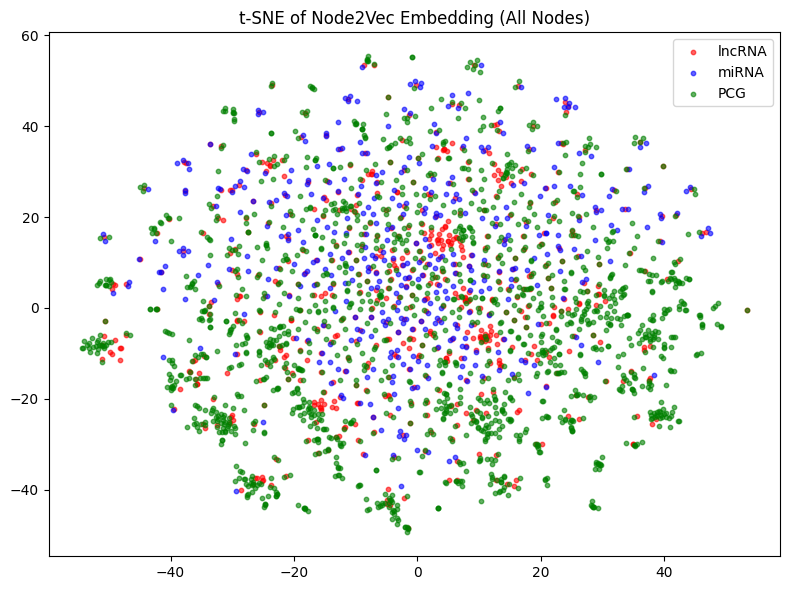

In [7]:
X = all_emb_df.iloc[:, :-1].values
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(8, 6))
type_colors = {'lncRNA': 'red', 'miRNA': 'blue', 'PCG': 'green'}
for t, color in type_colors.items():
    mask = (all_emb_df['NodeType'] == t)
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=t, c=color, s=10, alpha=0.6)
plt.title('t-SNE of Node2Vec Embedding (All Nodes)')
plt.legend()
plt.tight_layout()
plt.show()

D:\work\conda\ana\envs\RecGCN\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\work\conda\ana\envs\RecGCN\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\work\conda\ana\envs\RecGCN\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\work\conda\ana\envs\RecGCN\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1

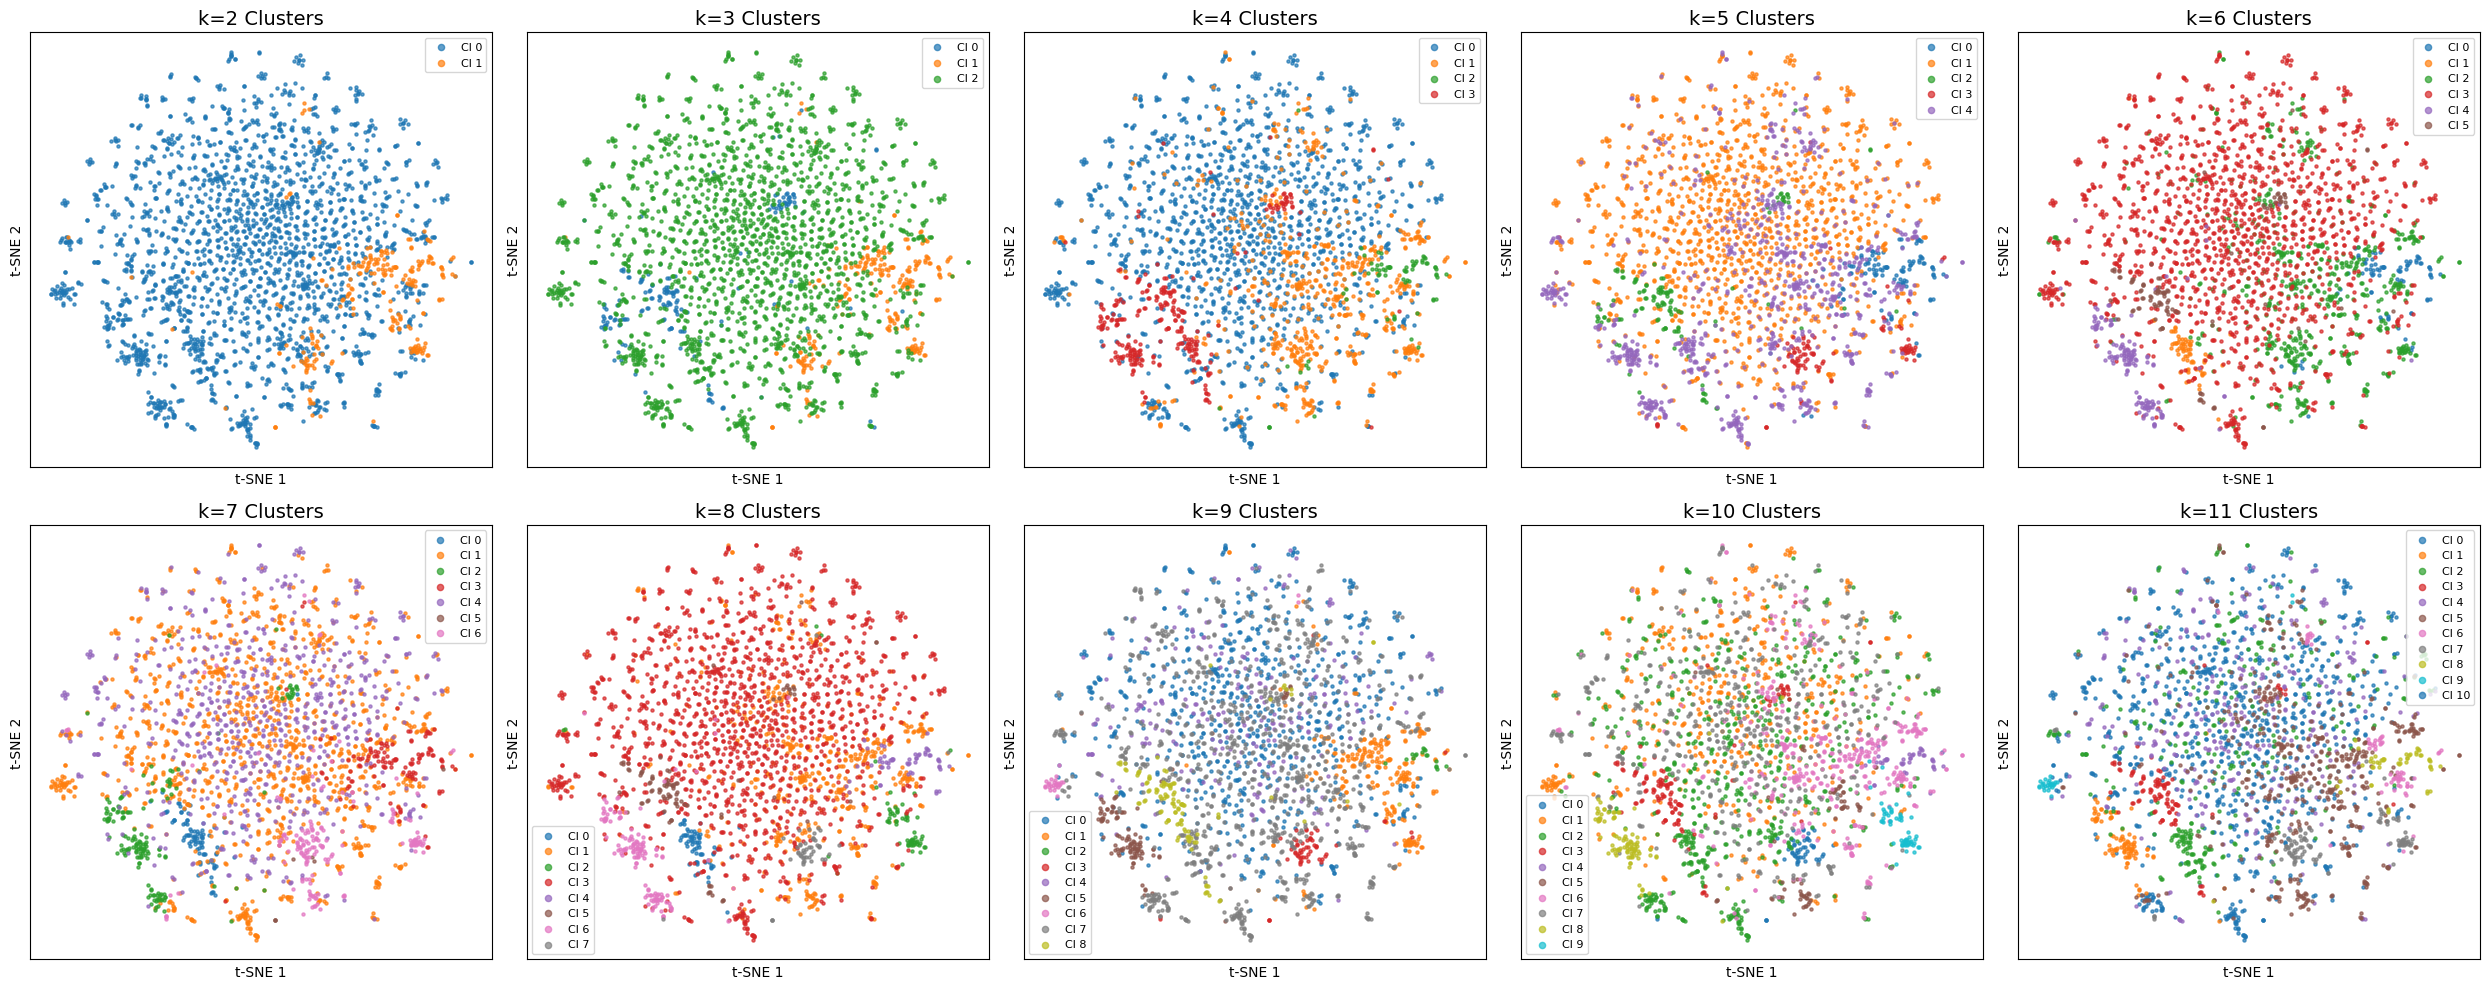

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()
cluster_features_df = pd.DataFrame(index=all_emb_df.index)

for idx, k in enumerate(range(2, 12)):
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(X)
    cluster_features_df[f'cluster_k{k}'] = clusters

    ax = axes[idx]
    for cluster_id in range(k):
        mask = clusters == cluster_id
        ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                   s=5, alpha=0.7, label=f'Cl {cluster_id}')
    ax.set_title(f'k={k} Clusters', fontsize=14)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(markerscale=2, loc='best', fontsize=8)

plt.tight_layout()
plt.show()

In [9]:
lncrna_cluster_features_df = cluster_features_df.loc[all_emb_df['NodeType'] == 'lncRNA']
print(lncrna_cluster_features_df)
lncrna_cluster_features_df.to_csv('lncRNA_cluster_features.csv')

            cluster_k2  cluster_k3  cluster_k4  cluster_k5  cluster_k6  \
Node                                                                     
NEAT1                0           2           1           4           2   
LINC00460            0           2           1           4           2   
MALAT1               0           2           1           4           2   
MIAT                 0           2           3           4           3   
CDKN2B-AS1           0           2           1           4           2   
...                ...         ...         ...         ...         ...   
ARAP1-AS2            0           2           0           1           3   
TLR8-AS1             0           2           0           1           3   
GAS1RR               0           2           1           4           2   
LINC01305            0           2           0           1           3   
LINC00554            0           2           1           4           2   

            cluster_k7  cluster_k8  c